In [14]:
import os
import platform
import subprocess
import pandas as pd
import numpy

RUNS = 5

FILENAME = 'CRS.csv'

def system_info():
    print(os.name, platform.system(), platform.release())
    print(os.popen("clinfo | grep -B 2 -A 4 'Device Vendor ID'").read())
    print(os.popen("clinfo | grep NOTE -A 3").read())
    
# Creating Pandas DataFrame 
if os.path.isfile(FILENAME):
    df = pd.read_csv(FILENAME)
else:
    df = pd.DataFrame({"version": [], "platform": [], "execution_time_ms": []})
    
# List previous data (average)
df.groupby(['platform', 'version']) \
  .agg({'version':'count', 'execution_time_ms':'mean'}) \
  .rename(columns={'version':'count','version':'executions'})

executions  \
platform                                   version               
Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz   SYCL              5   
Intel(R) Xeon(R) Silver 4208 CPU @ 2.10GHz OpenCL            5   
                                           SYCL              5   

                                                    execution_time_ms  
platform                                   version                     
Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz   SYCL               59515.0  
Intel(R) Xeon(R) Silver 4208 CPU @ 2.10GHz OpenCL              8936.0  
                                           SYCL                5516.8

# MacBook Pro (13-inch, 2017)

In [2]:
system_info()

('posix', 'Darwin', '19.4.0')
  Device Name                                     Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
  Device Vendor                                   Intel
  Device Vendor ID                                0xffffffff
  Device Version                                  OpenCL 1.2 
  Driver Version                                  1.1
  Device OpenCL C Version                         OpenCL C 1.2 
  Device Type                                     CPU
--
--
  Device Name                                     Intel(R) Iris(TM) Plus Graphics 640
  Device Vendor                                   Intel Inc.
  Device Vendor ID                                0x1024500
  Device Version                                  OpenCL 1.2 
  Driver Version                                  1.2(Mar 15 2020 21:29:48)
  Device OpenCL C Version                         OpenCL C 1.2 
  Device Type                                     GPU



# MacBook Pro (13-inch, 2017) + Docker

In [11]:
system_info()

posix Linux 4.19.76-linuxkit
  Device Name                                     Intel(R) FPGA Emulation Device
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x1172
  Device Version                                  OpenCL 1.2 
  Driver Version                                  2020.9.3.0.08_110447.xmain
  Device OpenCL C Version                         OpenCL C 1.2 
  Device Type                                     Accelerator
--
  Device Name                                     Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x8086
  Device Version                                  OpenCL 2.1 (Build 0)
  Driver Version                                  2020.10.4.0.15
  Device OpenCL C Version                         OpenCL C 2.0 
  Device Type                                     CPU



# GPU-server (Hermes) + Docker (oneAPI)

In [3]:
system_info()

posix Linux 4.15.0-65-generic
  Device Name                                     Intel(R) FPGA Emulation Device
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x1172
  Device Version                                  OpenCL 1.2 
  Driver Version                                  2020.9.3.0.08_110447.xmain
  Device OpenCL C Version                         OpenCL C 1.2 
  Device Type                                     Accelerator
--
  Device Name                                     Intel(R) Xeon(R) Silver 4208 CPU @ 2.10GHz
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x8086
  Device Version                                  OpenCL 2.1 (Build 0)
  Driver Version                                  2020.10.4.0.15
  Device OpenCL C Version                         OpenCL C 2.0 
  Device Type                                     CPU




## OpenCL version

In [11]:
for i in range(RUNS): 
    run = subprocess.Popen("./crs-ocl2 -aph 600 -apm 50 -a0 -0.7e-3 -a1 0.7e-3 -b0 -1e-7 -b1 1e-7 -c0 1.98e-7 -c1 1.77e-6 -na 5 -nb 5 -nc 5 -tau 0.002 -d 2 -i ../../../../datasets/simple-synthetic.su -v 0",
                           cwd = "OpenCL/build/",
                           shell = True,
                           stdout = subprocess.PIPE,
                           stderr = subprocess.PIPE,
                           universal_newlines = True)
    result = run.communicate()[0].split(",")
    df = df.append(pd.DataFrame({"version"          : ["OpenCL"], 
                                 "platform"         : ["Intel(R) Xeon(R) Silver 4208 CPU @ 2.10GHz"], 
                                 "execution_time_ms": [int(result[0])]}))
          
df.to_csv(FILENAME, index = False, header = True)

## OpenMP version

In [ ]:
for i in range(RUNS): 
    run = subprocess.Popen("./crs-omp2 -aph 600 -apm 50 -a0 -0.7e-3 -a1 0.7e-3 -b0 -1e-7 -b1 1e-7 -c0 1.98e-7 -c1 1.77e-6 -na 5 -nb 5 -nc 5 -tau 0.002 -i ../../../../datasets/simple-synthetic.su -v 0",
                           cwd = "OpenMP/build/",
                           shell = True,
                           stdout = subprocess.PIPE,
                           stderr = subprocess.PIPE,
                           universal_newlines = True)
    result = run.communicate()[0].split(",")
    df = df.append(pd.DataFrame({"version"          : ["OpenMP"], 
                                 "platform"         : ["Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz"], 
                                 "execution_time_ms": [int(result[0])]}))
          
df.to_csv(FILENAME, index = False, header = True)

## SYCL version (using Docker)

In [3]:
for i in range(RUNS): 
    run = subprocess.Popen("./crs-sycl2 -aph 600 -apm 50 -a0 -0.7e-3 -a1 0.7e-3 -b0 -1e-7 -b1 1e-7 -c0 1.98e-7 -c1 1.77e-6 -na 5 -nb 5 -nc 5 -tau 0.002 -i ../../../../datasets/simple-synthetic.su -v 0",
                           cwd = "SYCL/build/",
                           shell = True,
                           stdout = subprocess.PIPE,
                           stderr = subprocess.PIPE,
                           universal_newlines = True)
    result = run.communicate()[0].split(",")
    df = df.append(pd.DataFrame({"version"          : ["SYCL"], 
                                 "platform"         : ["Intel(R) Xeon(R) Silver 4208 CPU @ 2.10GHz"], 
                                 "execution_time_ms": [int(result[0])]}), sort=False)
          
df.to_csv(FILENAME, index = False, header = True)

Text(0, 0.5, 'Execution time (ms)')

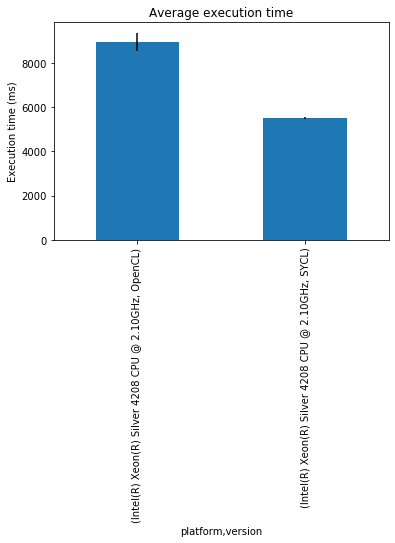

In [16]:
# Plot results
df = pd.read_csv(FILENAME)
by_version = df[df.platform == "Intel(R) Xeon(R) Silver 4208 CPU @ 2.10GHz"].groupby(['platform', 'version'])
avg_time = by_version.mean()
std = by_version.std()
plt = avg_time.plot(legend=False, kind="bar", yerr=std)
plt.set_title("Average execution time")
plt.set_ylabel("Execution time (ms)")